<a href="https://colab.research.google.com/github/basagliuz/Tirocinio/blob/main/Challenge_3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge 3
- Use the data file "challenge3.gwf" with channel "H1:CHALLENGE3".
- These are real LIGO data from O2, though we've adjusted the time labels and added some simulated signals.
- The data contain a loud simulated signal with m1 = m2 = 10 solar masses.


In [1]:
# Run once, then click "restart session" in the runtime menu and run again

! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc

# Download data
! wget https://dcc.ligo.org/public/0187/G2300818/001/challenge3.gwf
from gwpy.timeseries import TimeSeries
from pycbc import frame
gwpy_data = TimeSeries.read('challenge3.gwf', channel = "H1:CHALLENGE3")
pycbc_data = frame.read_frame('challenge3.gwf', 'H1:CHALLENGE3')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to buil

/usr/local/lib/python3.10/dist-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## First question
What is the merger time of this signal?

We first take a look at the data in time domain.

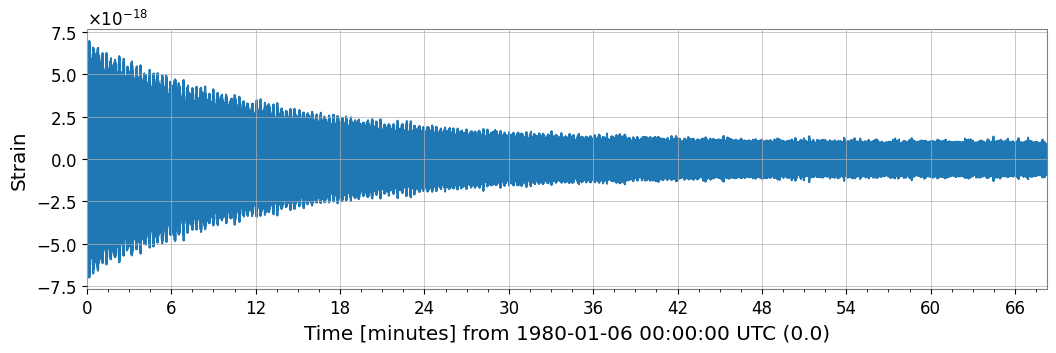

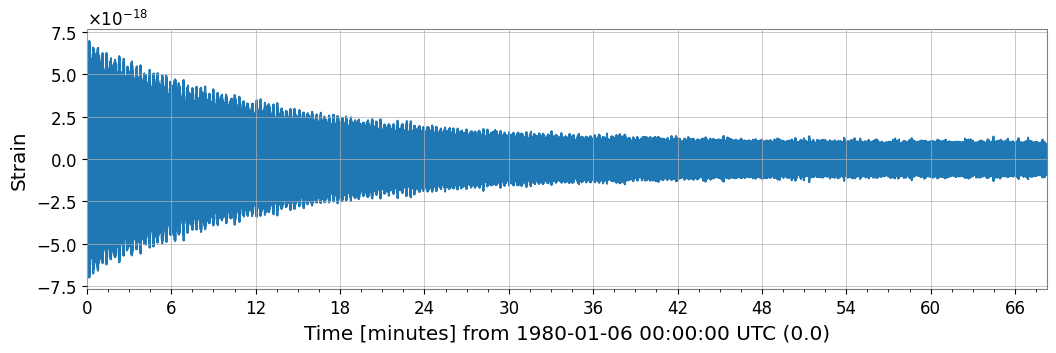

In [2]:
# Just a simple plot
gwpy_data.plot(ylabel = 'Strain')

As we can see the noise is not white. Anyway, the spectrogram seems aneffected.

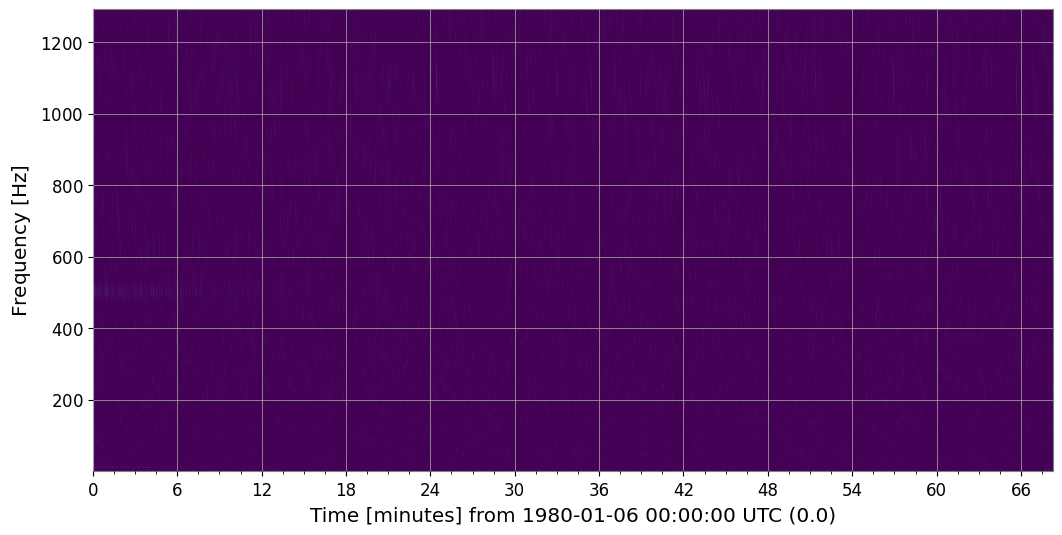

In [3]:
# Taking a spectrogram of the data
plot = gwpy_data.q_transform().plot()

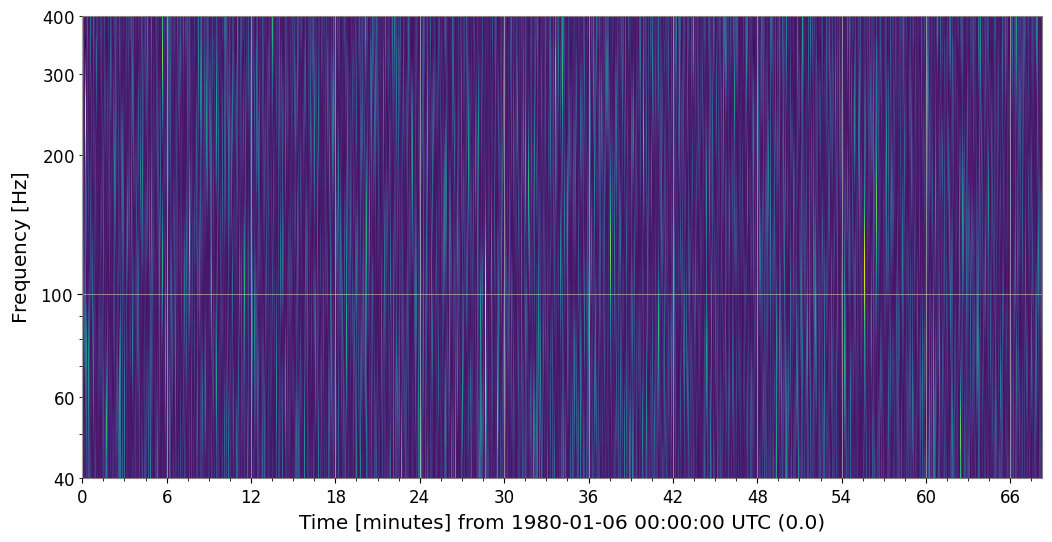

In [4]:
# Taking a more accurate spectrogram
plot = gwpy_data.q_transform(frange = (40, 400)).plot(yscale = 'log')

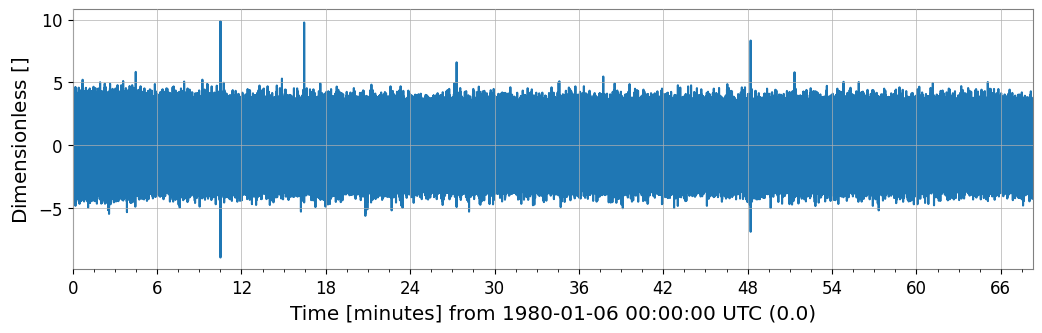

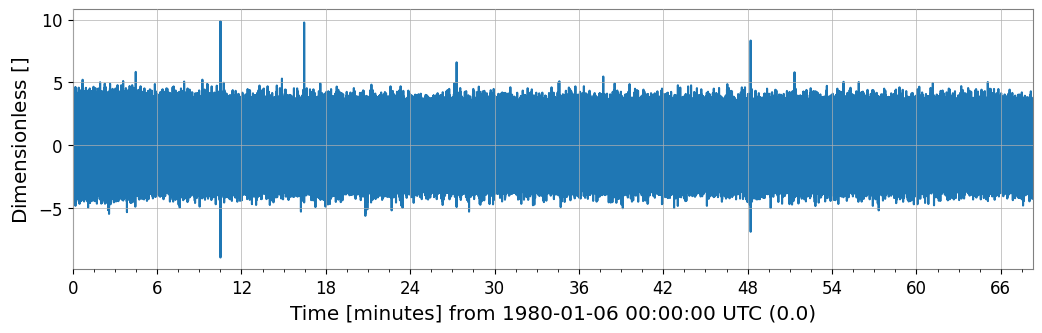

In [6]:
# Perhaps if we whiten the data
gwpy_data =  gwpy_data.whiten()
gwpy_data.plot()

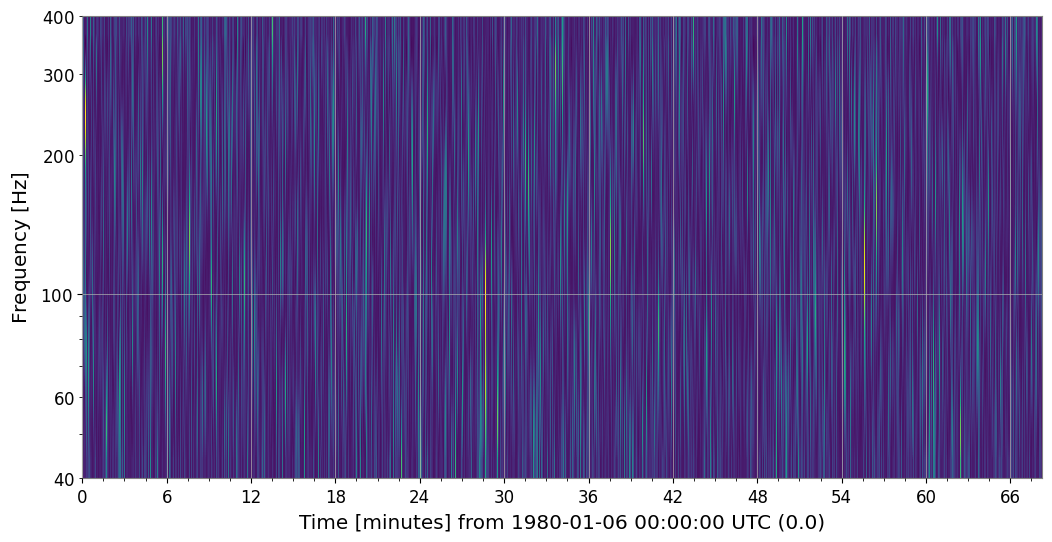

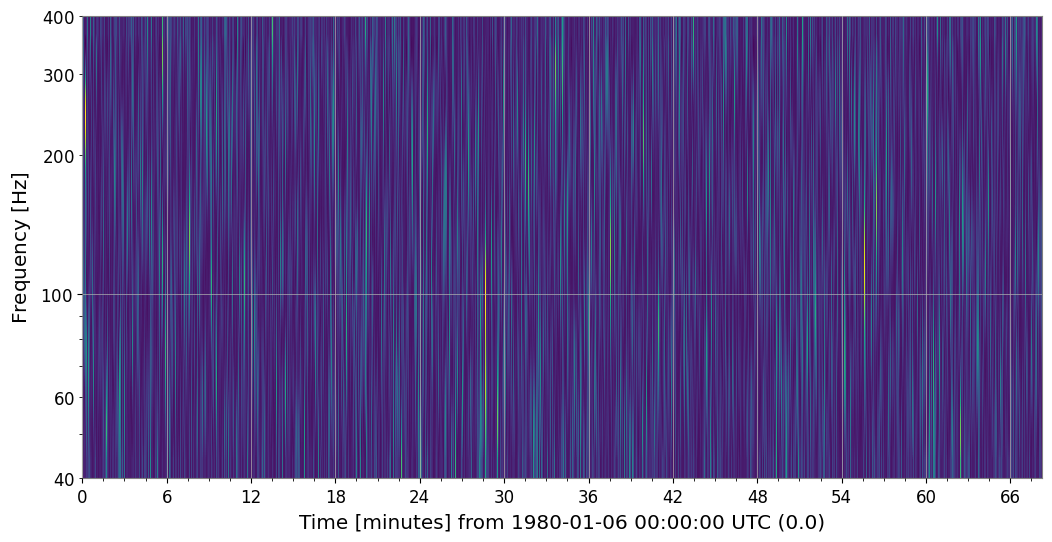

In [7]:
# Spectrogram second try
gwpy_data.q_transform(frange = (40, 400)).plot(yscale = 'log')

Since we cannot see anything from the spectrograms, the only thing we can do is a matched filtering approach. \
First we generate the waveform.

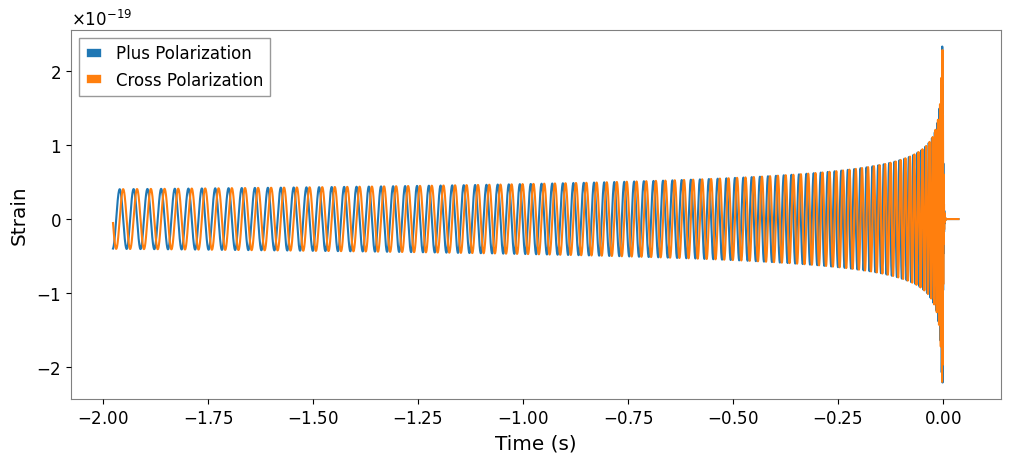

In [8]:
# Installing what we need to generate the waveform
from pycbc.waveform import get_td_waveform
import pylab

# Generating waveform
hp, hc = get_td_waveform(approximant = 'SEOBNRv4_opt',
                         mass1 = 10,
                         mass2 = 10,
                         delta_t = 1.0/4096,
                         f_lower = 30)

# Plotting waveform
pylab.figure(figsize = pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label = 'Plus Polarization')
pylab.plot(hp.sample_times, hc, label = 'Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

Then we proceed to evalueate the PSD.

In [9]:
# Preconditioning data
from pycbc.filter import highpass
pycbc_data = highpass(pycbc_data, 15)
pycbc_data = pycbc_data.crop(2, 2)

The Nyquist frequency is 2048.0 hz.


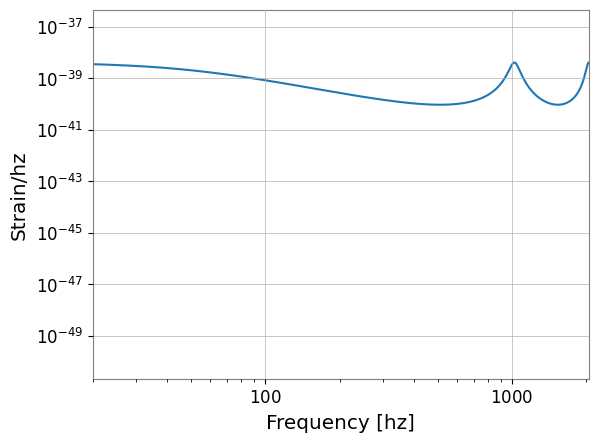

In [11]:
# Evaluetaing PSD
from pycbc.psd import interpolate, inverse_spectrum_truncation
psd = pycbc_data.psd(4)
psd = interpolate(psd, pycbc_data.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * pycbc_data.sample_rate), low_frequency_cutoff = 15)

# Evalueating Nyquist frequency
fn = pycbc_data.sample_rate / 2
print('The Nyquist frequency is {} hz.'.format(fn))

# Plotting the data
pylab.plot(psd)
pylab.xscale('log')
pylab.xlabel('Frequency [hz]')
pylab.xlim(20, fn)
pylab.yscale('log')
pylab.ylabel('Strain/hz')
pylab.show()

In [12]:
# Resizing and shifting our model
hp.resize(len(pycbc_data))
hp = hp.cyclic_time_shift(hp.start_time)

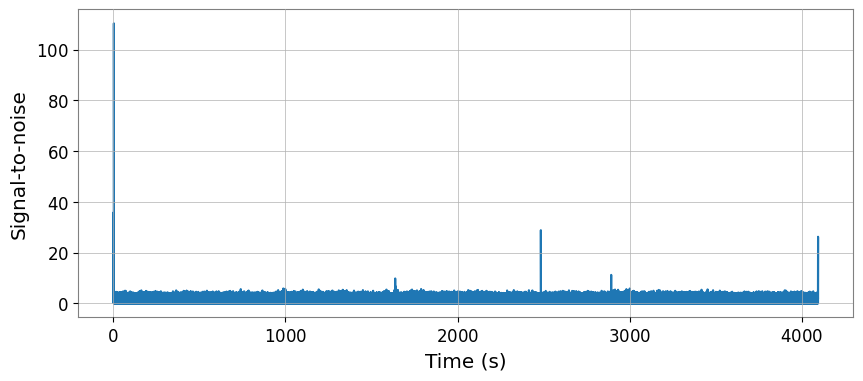

In [13]:
# Generating SNR from the PSD and our model (hp)
from pycbc.filter import matched_filter
import numpy
model = hp
data = pycbc_data
snr = matched_filter(model, data, psd = psd, low_frequency_cutoff = 15)

# Plotting the SNR
pylab.figure(figsize = [10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

In [14]:
# Where is the peak? What is its SNR?
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print("We found a peak at {} s with SNR {}.".format(time, abs(snrp)))

We found a peak at 3.975830078125 s with SNR 110.34827338605642.


I am not at all convinced by this SNR. Perhaps it is better to restart from scratch.